In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle

from helpers.evaluation import run_BDTs, run_NNs

In [5]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}


flow_training_id = "eta_eta"
project_id = "eta"

flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"processed_data/{project_id}_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"models/{flow_training_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()
    print(configs[0])
    


b"feature_set = ['muon_iso03', 'amuon_iso03', 'dimu_pt', 'dimu_eta', 'dimu_mass']\n"


In [6]:
# Assemble the test set

feature_set = ['muon_iso03', 'amuon_iso03', 'dimu_pt', 'dimu_eta', 'dimu_mass']

num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SR = np.empty((num_events_test_SR, len(feature_set)-1))
for i, feat in enumerate(feature_set[:-1]):
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)

print(test_events_SR.shape)

test_dimu_mass = test_dict["SR"]["s_inj_data"]["dimu_mass"].reshape(-1,)



(30537, 4)


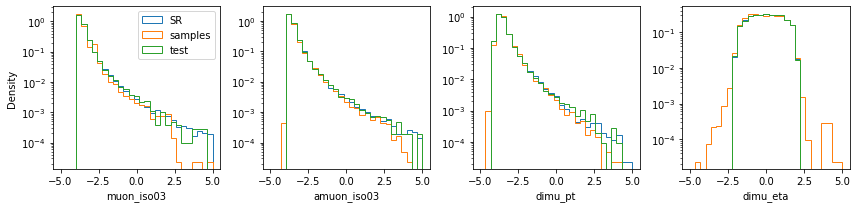

In [10]:
def hist_all_features(samples, labels, feature_set, plot_bound=3, yscale_log=False):
    
    n_bins = 30
      
    scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, n_bins) for i in range(len(feature_set))]   
    
    n_features = len(feature_set)
    fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
        

    for i, feat in enumerate(feature_set):
        for j, samp in enumerate(samples):
            ax[i].hist(samp[:,i], bins = scaled_feature_bins[i], histtype = "step", density = True, label = labels[j])
         
        if yscale_log:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
    ax[0].legend()
    ax[0].set_ylabel("Density")
    plt.tight_layout()
    plt.show()
  
hist_all_features([data_dict["SR"], data_dict["SR_samples"], test_events_SR], ["SR", "samples", "test"], feature_set[:-1], plot_bound = 5, yscale_log = True)

        

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier


def run_BDT_bump_hunt(train_samp_0, train_samp_1, test_samp, num_to_ensemble):
    
    X_train = np.vstack((train_samp_0, train_samp_1))
    Y_train = np.vstack((np.zeros((train_samp_0.shape[0], 1)), np.ones((train_samp_1.shape[0], 1))))
    
    print(X_train.shape, Y_train.shape)
    print(test_samp.shape)

    class_weight = {0: 1, 1: sum(Y_train==0)[0]/sum(Y_train==1)[0]}
    class_weights = class_weight[0]*(1.0-Y_train)+class_weight[1]*Y_train

    Y_train = Y_train.reshape(-1,)
    class_weights = class_weights.reshape(-1,)

    print("\nTraining class weights: ", class_weight)

    scores = {}

    for i in range(num_to_ensemble):
        
        print("Tree number:", i)
        np.random.seed(i+1)
        
        tree = HistGradientBoostingClassifier(verbose=0, max_iter=200, max_leaf_nodes=31, validation_fraction=0.5)
        results_f = tree.fit(X_train, Y_train, sample_weight=class_weights)
        loc_scores = tree.predict_proba(test_samp)[:,1]
        scores[i] = loc_scores
        
        del results_f
        
    return scores


In [ ]:
# Train a classifier to discriminate SR samples from SR data

scores = run_BDT_bump_hunt(data_dict["SR_samples"][:,:-1], data_dict["SR"][:,:-1], test_events_SR, 5)


In [ ]:
print(scores)


score_cutoff = 0.8



plt.figure()
for sc in [0, 0.3, 0.4, 0.6]:
    plt.hist(test_dimu_mass[scores[0]>sc], bins = np.linspace(-3.4, -3.1, 30), histtype = "step", label = sc)
plt.legend()
plt.show()